In [1]:
#from https://stackoverflow.com/a/31434967
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

<h1> Bank Marketing Campaign </h1>

We are provided with data on a recent marketing campaign conducted by a bank to encourage individuals to sign up for a term deposit. 

The challenge here is to build a model to be able to predict whether or not a given individual will sign up for a term subscription if contacted as part of this marketing campaign. 

This notebook will explore the dataset provided and use machine learning and statistical inferencing to build a predictive model. At the end, based on the insights generated by the model, we also provide suggestions on types of individuals to approach to increase the effectiveness of this campaign.

Kindly note that the approaches used in this model is based on https://www.kaggle.com/janiobachmann/bank-marketing-campaign-opening-a-term-deposit and https://machinelearningmastery.com/. Additional resources are included at the end of this notebook.

## 1. Import packages and data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.graph_objs as go
import squarify
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

seed=42

In [3]:
df_raw = pd.read_csv(r'DATA\bank.csv')
df_full = df_raw.copy()

## 2. Understand data

Copied from this kaggle notebook: https://www.kaggle.com/janiobachmann/bank-marketing-campaign-opening-a-term-deposit/notebook

1 - **age:** (numeric)<br>
2 - **job:** type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')<br>
3 - **marital:** marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)<br>
4 - **education:** (categorical: primary, secondary, tertiary and unknown)<br>
5 - **default:** has credit in default? (categorical: 'no','yes','unknown')<br>
6 - **housing:** has housing loan? (categorical: 'no','yes','unknown')<br>
7 - **loan:** has personal loan? (categorical: 'no','yes','unknown')<br>
8 - **balance:** Balance of the individual.<br>
9 - **month:** last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')<br>
10 - **day:** last contact day of the week (categorical: 'mon','tue','wed','thu','fri')<br>
11 - **duration:** last contact duration, in seconds (numeric).<br>
12 - **campaign:** number of contacts performed during this campaign and for this client (numeric, includes last contact)<br>
13 - **pdays:** number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)<br>
14 - **previous:** number of contacts performed before this campaign and for this client (numeric)<br>
15 - **poutcome:** outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')<br>
16 - **contact:** contact communication type (categorical: 'cellular','telephone') <br>

Output variable (desired target):<br>
17 - **y** - has the client subscribed a term deposit? (binary: 'yes','no')

In [4]:
df_full.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [5]:
df_full.shape

(11162, 17)

No missing values

In [6]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
age          11162 non-null int64
job          11162 non-null object
marital      11162 non-null object
education    11162 non-null object
default      11162 non-null object
balance      11162 non-null int64
housing      11162 non-null object
loan         11162 non-null object
contact      11162 non-null object
day          11162 non-null int64
month        11162 non-null object
duration     11162 non-null int64
campaign     11162 non-null int64
pdays        11162 non-null int64
previous     11162 non-null int64
poutcome     11162 non-null object
deposit      11162 non-null object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


Text(0, 0.5, '% Deposited')

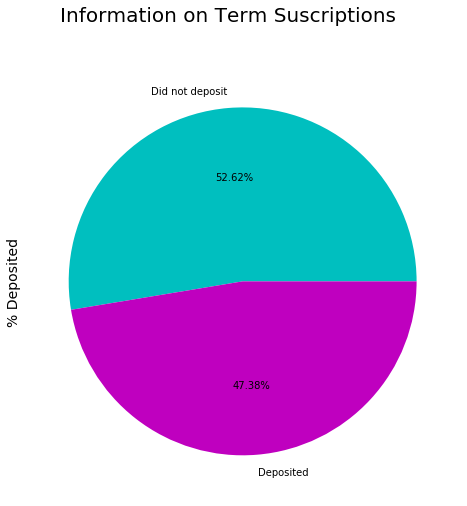

In [7]:
plt.figure(figsize=(16,8))
labels ="Did not deposit", "Deposited"
colors = ['c', 'm']
plt.suptitle('Information on Term Suscriptions', fontsize=20)
plt.pie(df_full["deposit"].value_counts(),autopct='%1.2f%%', labels=labels, colors=colors)
plt.ylabel('% Deposited', fontsize=14)

Distribution of numerical data

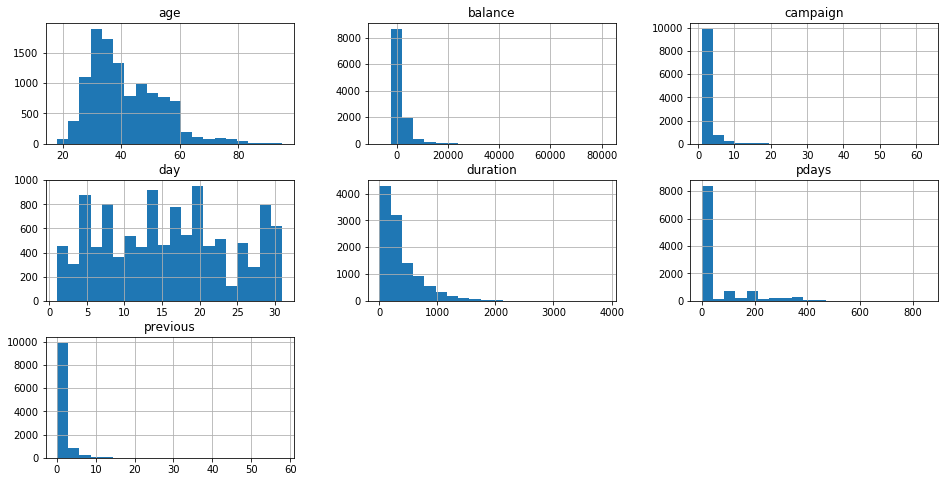

In [8]:
df_full.hist(bins=20, figsize=(16,8))
plt.show()

Hunch is that jobs impact likelihood of subscribing to term deposit.

Let's remove "unknown" job.

In [9]:
df_full = df_full.drop(df_full.loc[df_full.job=="unknown"].index)

And replace "admin" with management since fairly similar.

In [10]:
df_full.job = df_full.job.replace("admin.", "management")

In [11]:
df_full.job.value_counts()

management       3900
blue-collar      1944
technician       1823
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
Name: job, dtype: int64

Let's see correlations

#### Correlations

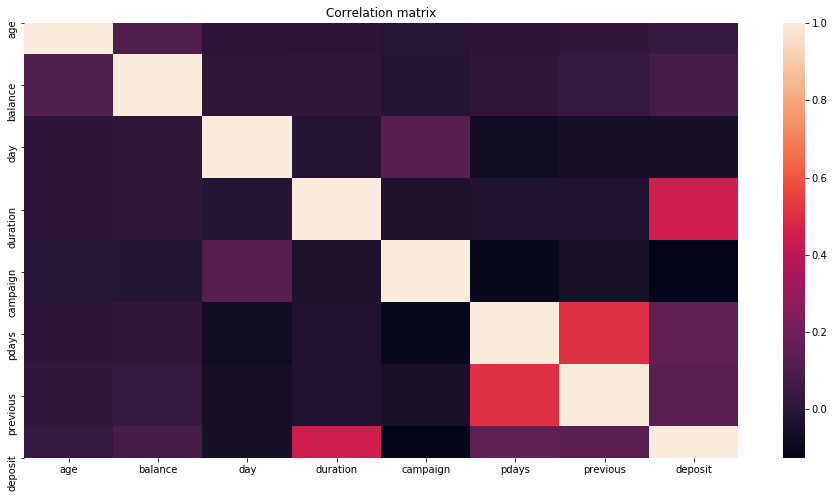

In [12]:
#need to one-hot encode our target variable
from sklearn.preprocessing import LabelEncoder

fig=plt.figure(figsize=(16,8))
df_full.deposit = LabelEncoder().fit_transform(df_full.deposit)

#we can only use numerical features for correlation analysis
numeric_df_full = df_full.select_dtypes(exclude="object")

cor_diagram = numeric_df_full.corr()

sns.heatmap(cor_diagram, cbar=True)
plt.title("Correlation matrix")
plt.show()

#### Duration vs deposit

From here, we see campaign last contact duration has the highest correlation with whether or not a person subscribes for a deposit.

In [235]:
df_full["duration_status"] = np.nan

avg_duration = df_full["duration"].mean()

df_full["duration_status"] = df_full.apply(lambda row: "below_average" if row.duration<avg_duration else "above_average",axis=1 )

yes_no_by_durationstatus = pd.crosstab(df_full['duration_status'], df_full['deposit']).apply(lambda row: round(row/row.sum(),4) * 100, axis=1)
yes_no_by_durationstatus

deposit,no,yes
duration_status,,
above_average,22.63,77.37
below_average,68.38,31.62


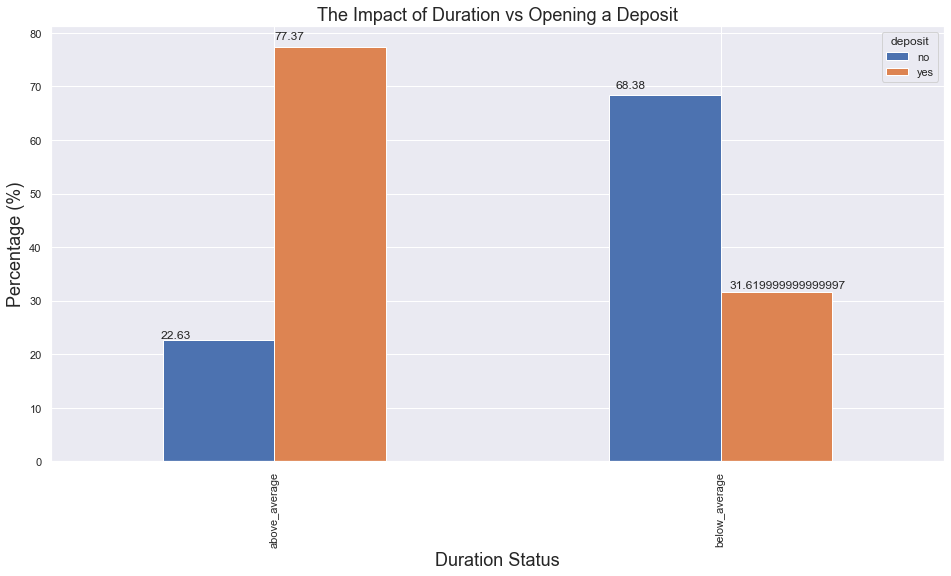

In [236]:
sns.set(rc={'figure.figsize':(16,8)})
ax = yes_no_by_durationstatus.plot(kind='bar', stacked=False)
plt.title("The Impact of Duration vs Opening a Deposit", fontsize=18)
plt.xlabel("Duration Status", fontsize=18);
plt.ylabel("Percentage (%)", fontsize=18)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.02, p.get_height() * 1.02))
    

plt.show()

From here, we see that if you had an above average duration in last campaign, and you were contacted again, majority would subscribe. Conversely, if you had a short duration of contact in last campaign, and you were contacted again, majority would not subscribe to a deposit. This is possibly a sign of interest and/or rapport. Ie customers we spent more time talking to were more open to subscribing.

#### Balance vs deposit

In [231]:
df_full['temp_balance'] = np.ceil(df_full["balance"]/10000)*10000
yes_no_by_temp_balance = pd.crosstab(df_full['temp_balance'], df_full['deposit']).apply(lambda row: round(row/row.sum(),4) * 100, axis=1)
yes_no_by_temp_balance

deposit,no,yes
temp_balance,,
0.0,65.66,34.34
10000.0,50.89,49.11
20000.0,38.01,61.99
30000.0,51.22,48.78
40000.0,50.00,50.00
50000.0,0.00,100.00
60000.0,50.00,50.00
70000.0,100.00,0.00
90000.0,0.00,100.00


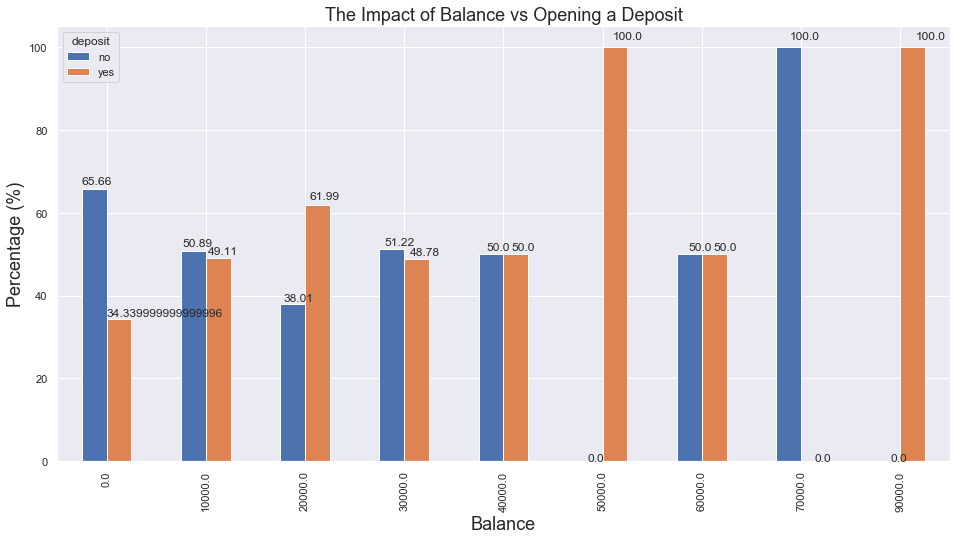

In [232]:
sns.set(rc={'figure.figsize':(16,8)})
ax = yes_no_by_temp_balance.plot(kind='bar', stacked=False)
plt.title("The Impact of Balance vs Opening a Deposit", fontsize=18)
plt.xlabel("Balance", fontsize=18);
plt.ylabel("Percentage (%)", fontsize=18)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.02, p.get_height() * 1.02))
    

plt.show()

From the above, we see that generally those who did not subscribe to a term deposit tend to have lower bank balances. 

Note: 0 here means they had negative balances ie they were in overdraft.

#### Age vs deposit

In [128]:
df_full['temp_age'] = np.ceil(df_full["age"]/10)*10
yes_no_by_temp_age = pd.crosstab(df_full['temp_age'], df_full['deposit']).apply(lambda row: round(row/row.sum(),4) * 100, axis=1)
yes_no_by_temp_age

deposit,no,yes
temp_age,,
20.0,19.51,80.49
30.0,43.44,56.56
40.0,56.73,43.27
50.0,59.17,40.83
60.0,56.40,43.60
70.0,15.98,84.02
80.0,19.72,80.28
90.0,24.00,76.00
100.0,0.00,100.00


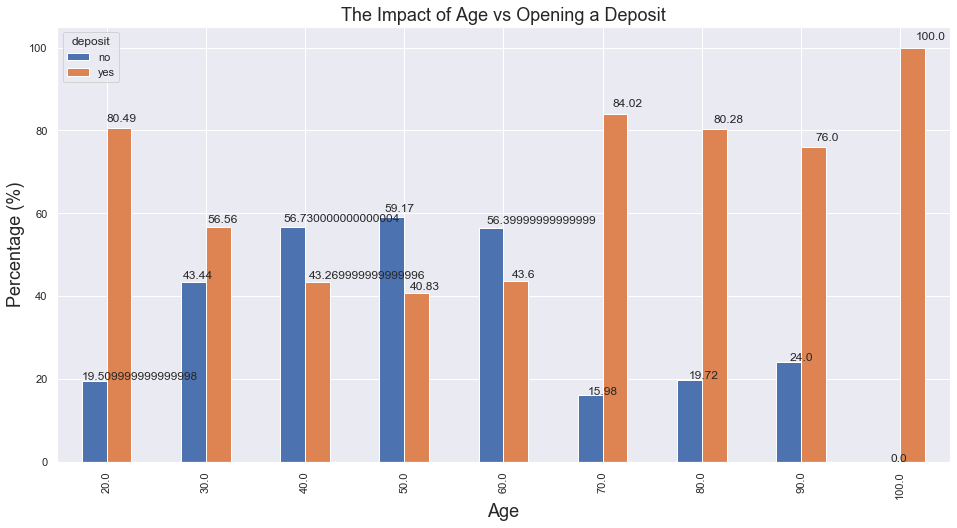

In [130]:
sns.set(rc={'figure.figsize':(16,8)})
ax = yes_no_by_temp_age.plot(kind='bar', stacked=False)
plt.title("The Impact of Age vs Opening a Deposit", fontsize=18)
plt.xlabel("Age", fontsize=18);
plt.ylabel("Percentage (%)", fontsize=18)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.02, p.get_height() * 1.02))
    

plt.show()

From the above, if you were very young or a senior citizen, you were more likely to subscribe to a bank deposit.

#### Pdays vs deposit

In [158]:
df_full['temp_pdays_bucket'] = df_full.apply(lambda row: 0 if row['pdays']<=0 else 1 if row['pdays']<=30 else 2 if row['pdays']<=60 else 3 if row['pdays']<=90 else 6 if row['pdays']<=180 else 12 if row['pdays']<=365 else 24 if row['pdays']<=730 else 25,axis=1)

In [159]:
df_full['temp_pdays_bucket'].value_counts()

0     8324
12    1307
6      950
24     235
3      224
1       56
2       49
25      17
Name: temp_pdays_bucket, dtype: int64

In [160]:
yes_no_by_temp_pdays = pd.crosstab(df_full['temp_pdays_bucket'], df_full['deposit']).apply(lambda row: round(row/row.sum(),4) * 100, axis=1)
yes_no_by_temp_pdays

deposit,no,yes
temp_pdays_bucket,,
0,59.35,40.65
1,50.00,50.00
2,18.37,81.63
3,18.30,81.70
6,28.42,71.58
12,39.86,60.14
24,25.11,74.89
25,29.41,70.59


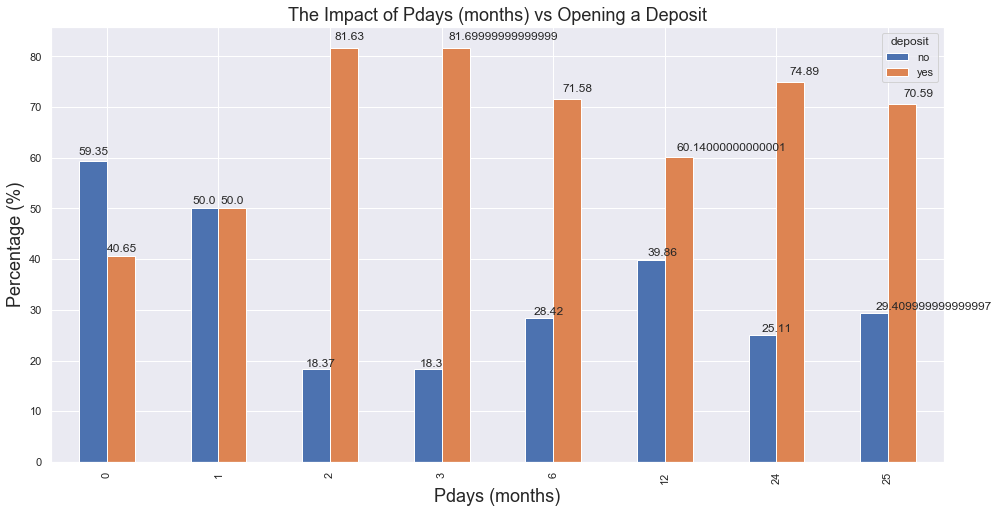

In [162]:
sns.set(rc={'figure.figsize':(16,8)})
ax = yes_no_by_temp_pdays.plot(kind='bar', stacked=False)#, order=['0m','1m','2m', '3m', '6m','12m', '24m', '>24m'])
plt.title("The Impact of Pdays (months) vs Opening a Deposit", fontsize=18)
plt.xlabel("Pdays (months)", fontsize=18);
plt.ylabel("Percentage (%)", fontsize=18)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.02, p.get_height() * 1.02))
    

plt.show()

Not clear but appears to suggest that if someone was recently contacted, and if they were contacted again this time, they were more likely to decline the offer to subscribe. Seems to suggest that the longer someone has not been contacted, the more likely they are to subscribe.

Note: 0 means they were just contacted. 25 means more than 24 months since last contact

#### Campaign vs deposit

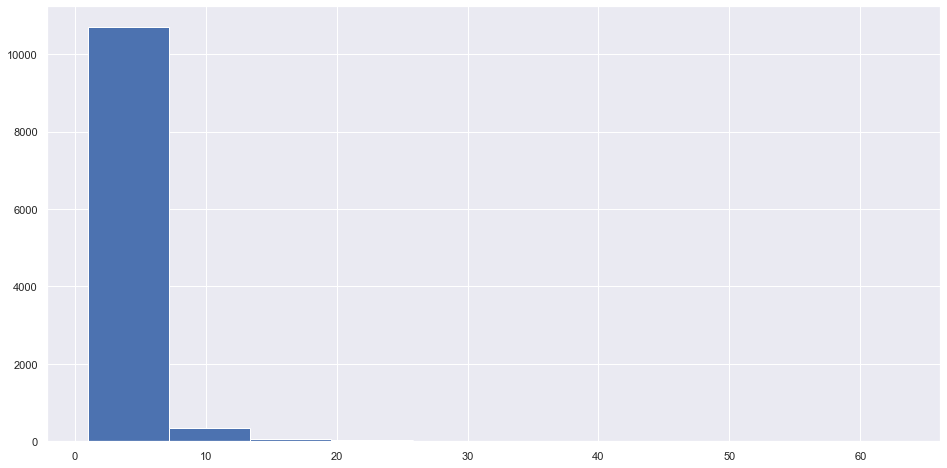

In [165]:
df_full['campaign'].hist()

In [166]:
df_full['temp_campaign'] = df_full.apply(lambda row: 11 if row['campaign']>=11 else row['campaign'],axis=1)

In [167]:
yes_no_by_temp_campaign = pd.crosstab(df_full['temp_campaign'], df_full['deposit']).apply(lambda row: round(row/row.sum(),4) * 100, axis=1)
yes_no_by_temp_campaign

deposit,no,yes
temp_campaign,,
1,46.62,53.38
2,53.73,46.27
3,53.22,46.78
4,58.88,41.12
5,63.23,36.77
6,65.28,34.72
7,66.19,33.81
8,75.00,25.00
9,70.83,29.17


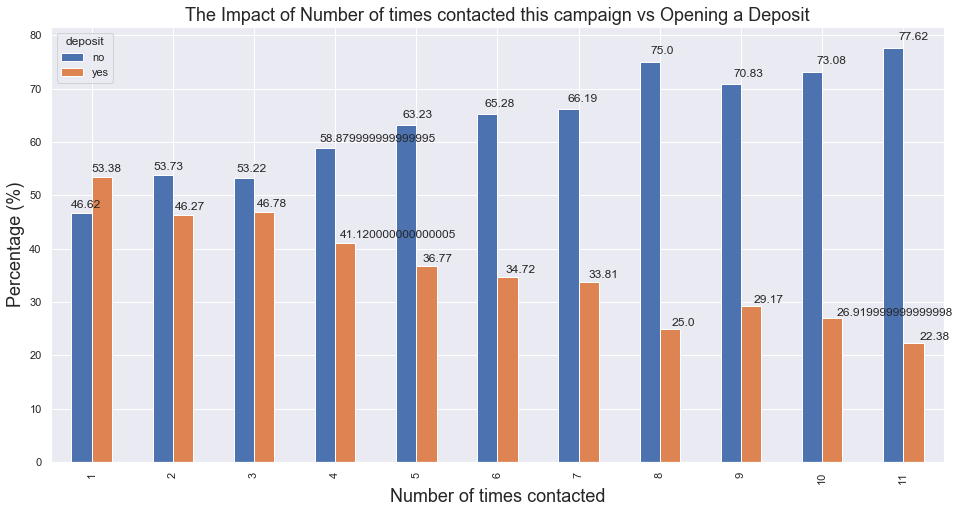

In [168]:
sns.set(rc={'figure.figsize':(16,8)})
ax = yes_no_by_temp_campaign.plot(kind='bar', stacked=False)#, order=['0m','1m','2m', '3m', '6m','12m', '24m', '>24m'])
plt.title("The Impact of Number of times contacted this campaign vs Opening a Deposit", fontsize=18)
plt.xlabel("Number of times contacted", fontsize=18);
plt.ylabel("Percentage (%)", fontsize=18)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.02, p.get_height() * 1.02))
    

plt.show()

From the above, repeat contacts make it even less likely for someone to subscribe.

#### Previous outcome vs deposit

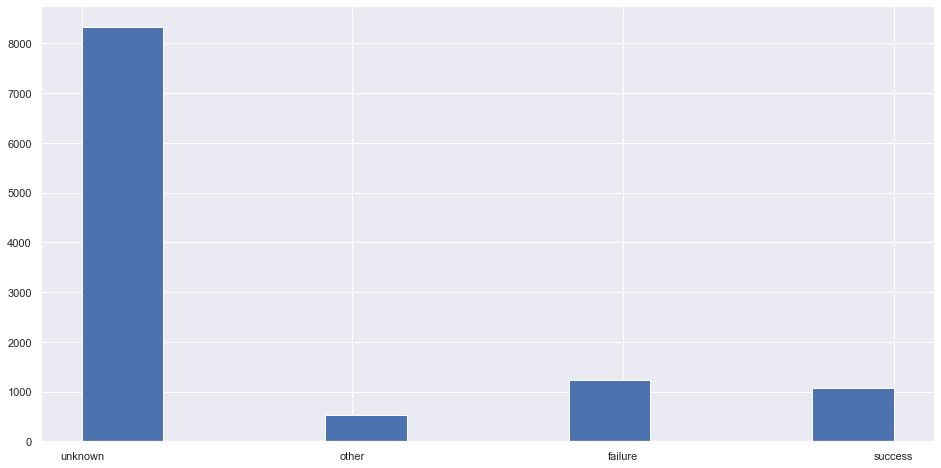

In [169]:
df_full['poutcome'].hist()

In [170]:
yes_no_by_poutcome = pd.crosstab(df_full['poutcome'], df_full['deposit']).apply(lambda row: round(row/row.sum(),4) * 100, axis=1)
yes_no_by_poutcome

deposit,no,yes
poutcome,,
failure,49.67,50.33
other,42.83,57.17
success,8.68,91.32
unknown,59.33,40.67


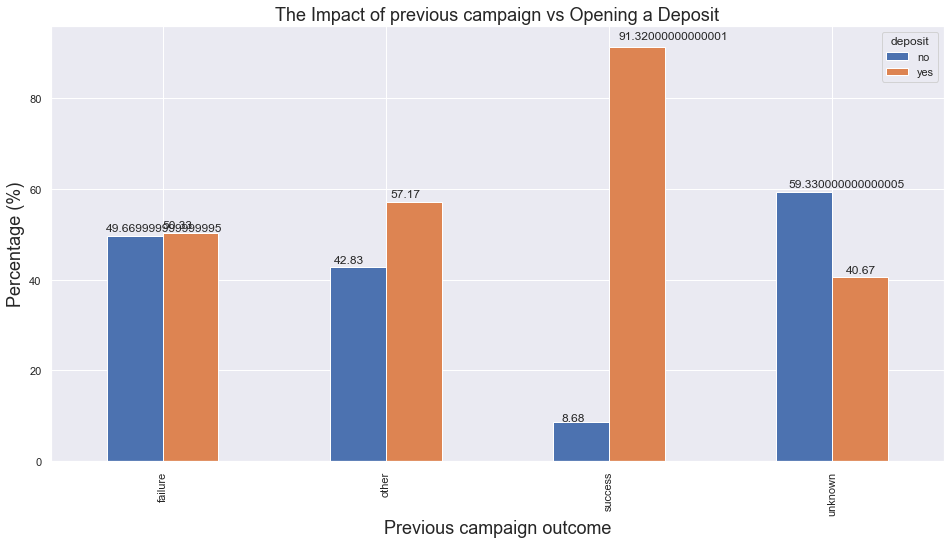

In [171]:
sns.set(rc={'figure.figsize':(16,8)})
ax = yes_no_by_poutcome.plot(kind='bar', stacked=False)#, order=['0m','1m','2m', '3m', '6m','12m', '24m', '>24m'])
plt.title("The Impact of previous campaign vs Opening a Deposit", fontsize=18)
plt.xlabel("Previous campaign outcome", fontsize=18);
plt.ylabel("Percentage (%)", fontsize=18)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.02, p.get_height() * 1.02))
    

plt.show()

If previous outcome was succesful, you were overwhelmingly more likely to subscribe.

#### Number of times contacted in previous campaign vs outcome of this campaign

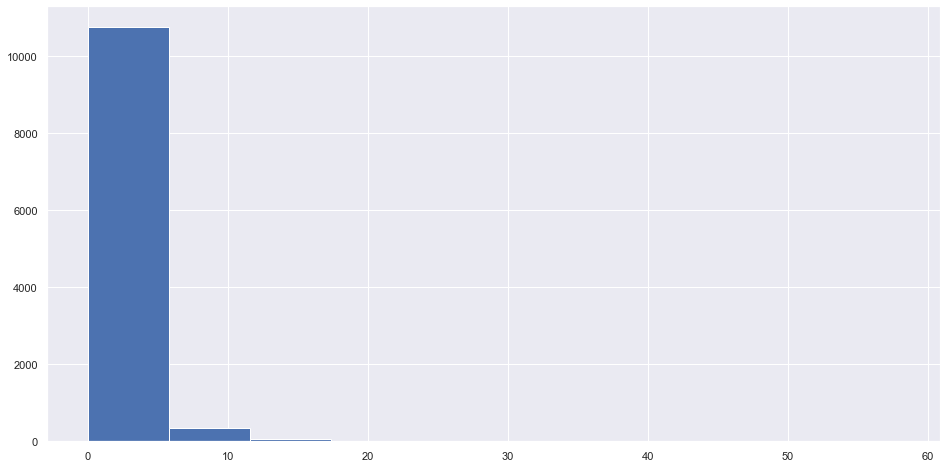

In [172]:
df_full['previous'].hist()

In [174]:
df_full['temp_previous'] = df_full.apply(lambda row: 11 if row['previous']>=11 else row['previous'],axis=1)

In [175]:
yes_no_by_temp_previous = pd.crosstab(df_full['temp_previous'], df_full['deposit']).apply(lambda row: round(row/row.sum(),4) * 100, axis=1)
yes_no_by_temp_previous

deposit,no,yes
temp_previous,,
0,59.35,40.65
1,34.27,65.73
2,34.20,65.80
3,32.41,67.59
4,29.92,70.08
5,26.67,73.33
6,29.06,70.94
7,29.87,70.13
8,35.00,65.00


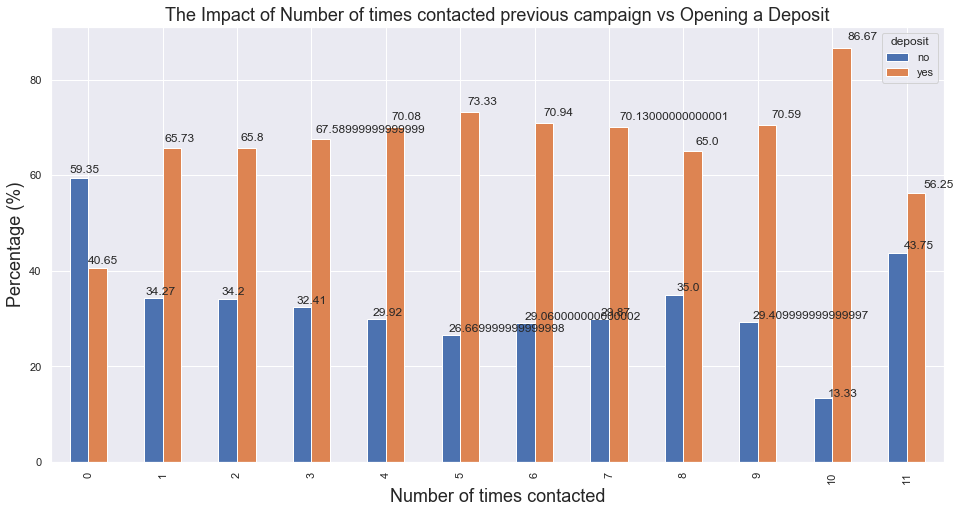

In [176]:
sns.set(rc={'figure.figsize':(16,8)})
ax = yes_no_by_temp_previous.plot(kind='bar', stacked=False)#, order=['0m','1m','2m', '3m', '6m','12m', '24m', '>24m'])
plt.title("The Impact of Number of times contacted previous campaign vs Opening a Deposit", fontsize=18)
plt.xlabel("Number of times contacted", fontsize=18);
plt.ylabel("Percentage (%)", fontsize=18)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.02, p.get_height() * 1.02))
    

plt.show()

Interestingly, the more you contacted someone in previous campaign, the more likely they were to subscribe to a term deposit.
Conversely, if they had never heard from you before (not contacted from previous campaign), they were less likely to subscribe this time.

Note that there may be some correlations between 'duration', 'previous contact times' and 'previous outcome'. As we are likely to use a tree-based model, multicollinearity is not an issue but we will be testing this assumption in order to flush out what exactly are key predictors.

For now, let's visualise these features.

#### Duration vs deposit, given success of previous campaign

In [241]:
df_full["duration_status"] = np.nan

avg_duration = df_full["duration"].mean()

df_full["duration_status"] = df_full.apply(lambda row: "below_average" if row.duration<avg_duration else "above_average",axis=1 )

yes_no_by_durationstatus = pd.crosstab(df_full[df_full['poutcome']=="success"]['duration_status'], df_full[df_full['poutcome']=="success"]['deposit']).apply(lambda row: round(row/row.sum(),4) * 100, axis=1)
yes_no_by_durationstatus

deposit,no,yes
duration_status,,
above_average,3.61,96.39
below_average,10.96,89.04


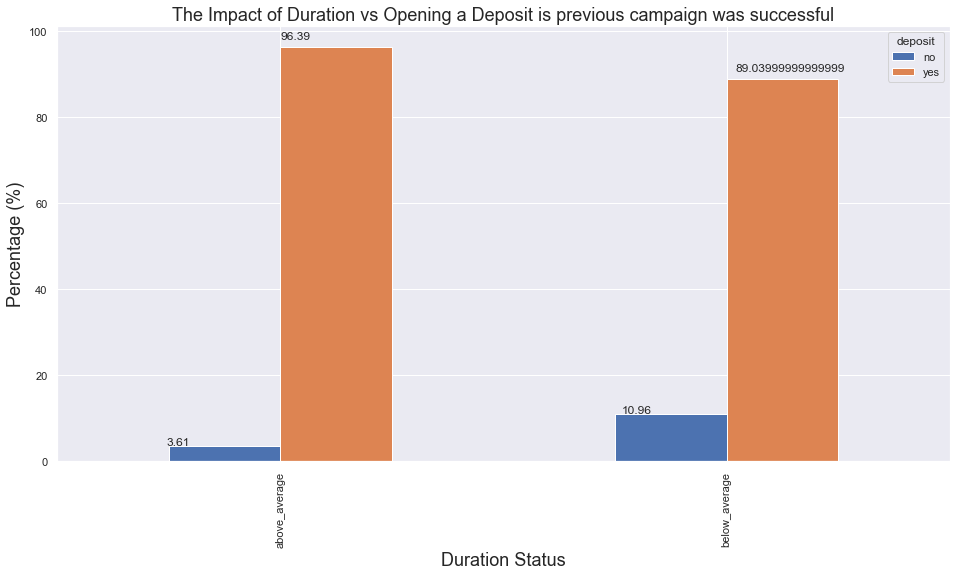

In [242]:
sns.set(rc={'figure.figsize':(16,8)})
ax = yes_no_by_durationstatus.plot(kind='bar', stacked=False)
plt.title("The Impact of Duration vs Opening a Deposit is previous campaign was successful", fontsize=18)
plt.xlabel("Duration Status", fontsize=18);
plt.ylabel("Percentage (%)", fontsize=18)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.02, p.get_height() * 1.02))
    

plt.show()


In [245]:


df_full["duration_status"] = np.nan

avg_duration = df_full["duration"].mean()

df_full["duration_status"] = df_full.apply(lambda row: "below_average" if row.duration<avg_duration else "above_average",axis=1 )

yes_no_by_durationstatus = pd.crosstab(df_full[df_full['poutcome']=="failure"]['duration_status'], df_full[df_full['poutcome']=="failure"]['deposit']).apply(lambda row: round(row/row.sum(),4) * 100, axis=1)
yes_no_by_durationstatus



deposit,no,yes
duration_status,,
above_average,22.07,77.93
below_average,61.85,38.15


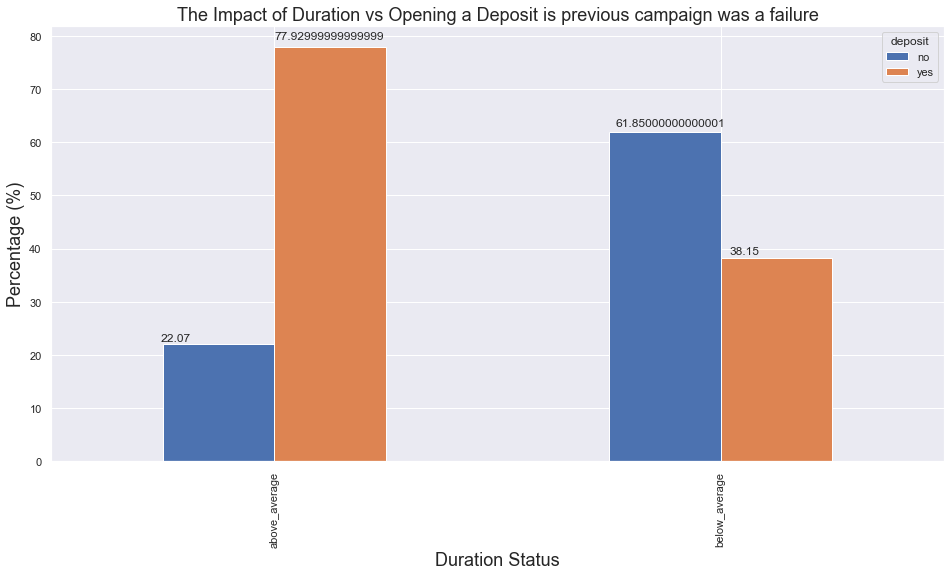

In [247]:
sns.set(rc={'figure.figsize':(16,8)})
ax = yes_no_by_durationstatus.plot(kind='bar', stacked=False)
plt.title("The Impact of Duration vs Opening a Deposit is previous campaign was a failure", fontsize=18)
plt.xlabel("Duration Status", fontsize=18);
plt.ylabel("Percentage (%)", fontsize=18)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.02, p.get_height() * 1.02))
    

plt.show()

From here, it suggests that if your previous outcome was not a success and if you spent a lot of time in contact with them in that failed campaign, it is unlikely you would see much success in a repeat campaign.

(From earlier sections, we already know that prior campaign success seems to relate with a repeat success!)

#### Number of days contacted in previous campaign vs success in this campaign, given success of previous campaign

In [248]:
df_full['temp_previous'] = df_full.apply(lambda row: 11 if row['previous']>=11 else row['previous'],axis=1)

In [249]:
yes_no_by_temp_previous = pd.crosstab(df_full[df_full['poutcome']=="success"]['temp_previous'], df_full[df_full['poutcome']=="success"]['deposit']).apply(lambda row: round(row/row.sum(),4) * 100, axis=1)
yes_no_by_temp_previous

deposit,no,yes
temp_previous,,
1,7.67,92.33
2,10.48,89.52
3,11.86,88.14
4,5.00,95.00
5,7.25,92.75
6,2.08,97.92
7,10.34,89.66
8,8.70,91.30
9,7.14,92.86


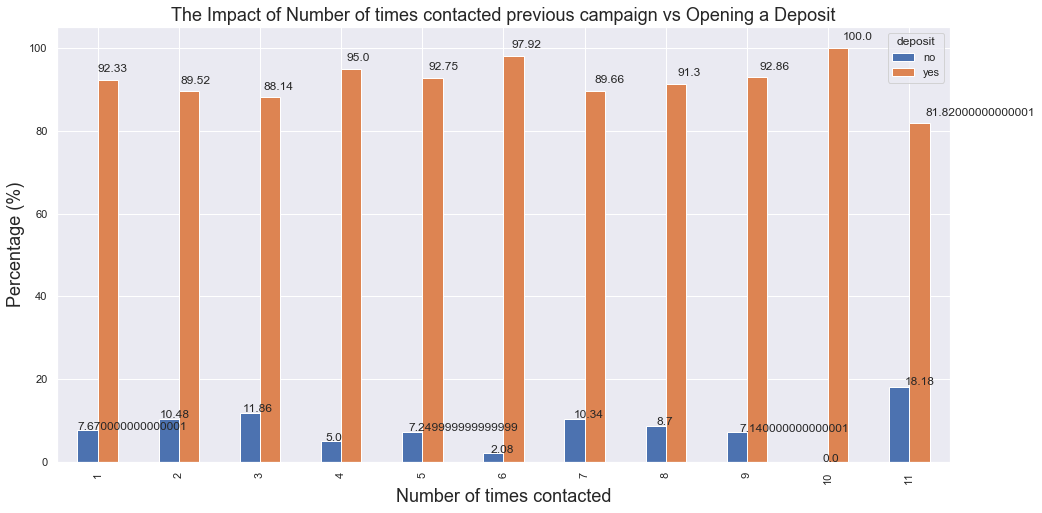

In [250]:
sns.set(rc={'figure.figsize':(16,8)})
ax = yes_no_by_temp_previous.plot(kind='bar', stacked=False)#, order=['0m','1m','2m', '3m', '6m','12m', '24m', '>24m'])
plt.title("The Impact of Number of times contacted previous campaign vs Opening a Deposit if previous campaign successful", fontsize=18)
plt.xlabel("Number of times contacted", fontsize=18);
plt.ylabel("Percentage (%)", fontsize=18)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.02, p.get_height() * 1.02))
    

plt.show()

In [251]:
yes_no_by_temp_previous = pd.crosstab(df_full[df_full['poutcome']=="failure"]['temp_previous'], df_full[df_full['poutcome']=="failure"]['deposit']).apply(lambda row: round(row/row.sum(),4) * 100, axis=1)
yes_no_by_temp_previous

deposit,no,yes
temp_previous,,
1,52.74,47.26
2,50.00,50.00
3,45.00,55.00
4,49.48,50.52
5,40.62,59.38
6,58.70,41.30
7,46.88,53.12
8,45.00,55.00
9,46.15,53.85


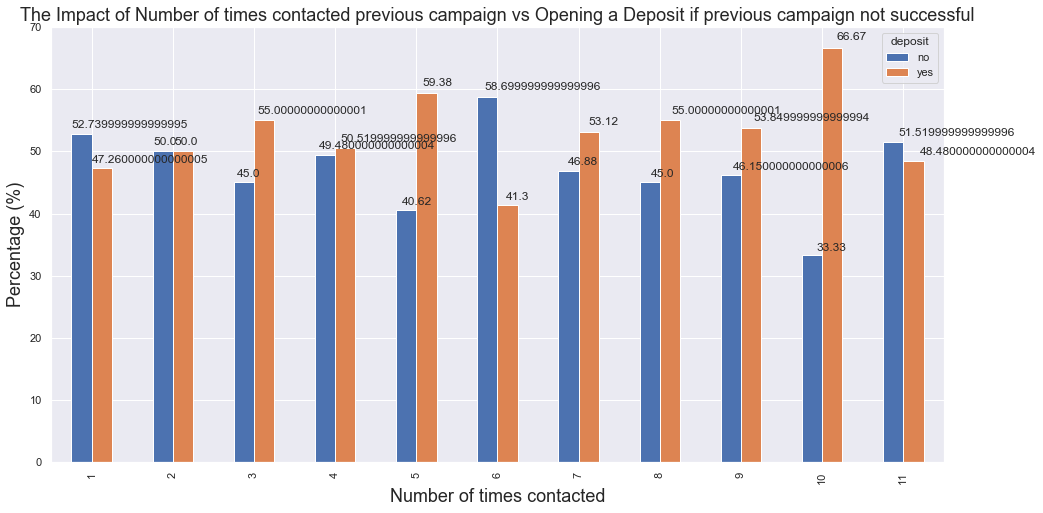

In [252]:
sns.set(rc={'figure.figsize':(16,8)})
ax = yes_no_by_temp_previous.plot(kind='bar', stacked=False)#, order=['0m','1m','2m', '3m', '6m','12m', '24m', '>24m'])
plt.title("The Impact of Number of times contacted previous campaign vs Opening a Deposit if previous campaign not successful", fontsize=18)
plt.xlabel("Number of times contacted", fontsize=18);
plt.ylabel("Percentage (%)", fontsize=18)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.02, p.get_height() * 1.02))
    

plt.show()

From the above, if the previous campaign failed, it is not exactly clear whether or not an existing 'rapport' (by way of having contacted them a few times before) is actually helpful in convincing them to sign up this time.

(From earlier sections, we already know that prior campaign success seems to relate with a repeat success!)

#### Days since last campaign vs success of this campaign, given success of previous campaign

In [253]:
df_full['temp_pdays_bucket'] = df_full.apply(lambda row: 0 if row['pdays']<=0 else 1 if row['pdays']<=30 else 2 if row['pdays']<=60 else 3 if row['pdays']<=90 else 6 if row['pdays']<=180 else 12 if row['pdays']<=365 else 24 if row['pdays']<=730 else 25,axis=1)

In [254]:
yes_no_by_temp_pdays = pd.crosstab(df_full[df_full['poutcome']=="success"]['temp_pdays_bucket'], df_full[df_full['poutcome']=="success"]['deposit']).apply(lambda row: round(row/row.sum(),4) * 100, axis=1)
yes_no_by_temp_pdays

deposit,no,yes
temp_pdays_bucket,,
1,7.14,92.86
2,13.33,86.67
3,10.74,89.26
6,10.76,89.24
12,5.87,94.13
24,7.02,92.98
25,100.00,0.00


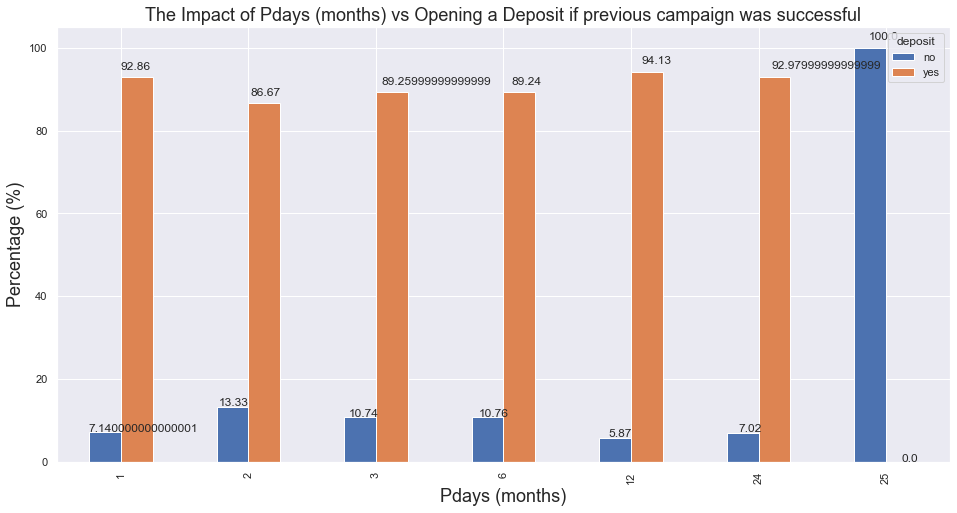

In [255]:
sns.set(rc={'figure.figsize':(16,8)})
ax = yes_no_by_temp_pdays.plot(kind='bar', stacked=False)#, order=['0m','1m','2m', '3m', '6m','12m', '24m', '>24m'])
plt.title("The Impact of Pdays (months) vs Opening a Deposit if previous campaign was successful", fontsize=18)
plt.xlabel("Pdays (months)", fontsize=18);
plt.ylabel("Percentage (%)", fontsize=18)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.02, p.get_height() * 1.02))
    

plt.show()

In [256]:
yes_no_by_temp_pdays = pd.crosstab(df_full[df_full['poutcome']=="failure"]['temp_pdays_bucket'], df_full[df_full['poutcome']=="failure"]['deposit']).apply(lambda row: round(row/row.sum(),4) * 100, axis=1)
yes_no_by_temp_pdays

deposit,no,yes
temp_pdays_bucket,,
1,44.44,55.56
2,19.05,80.95
3,30.56,69.44
6,47.04,52.96
12,59.22,40.78
24,30.30,69.70
25,25.00,75.00


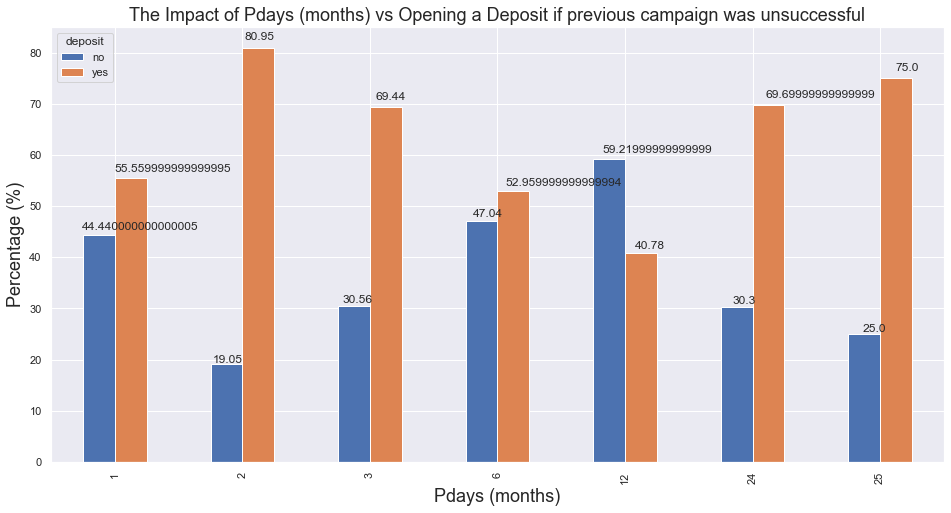

In [257]:
sns.set(rc={'figure.figsize':(16,8)})
ax = yes_no_by_temp_pdays.plot(kind='bar', stacked=False)#, order=['0m','1m','2m', '3m', '6m','12m', '24m', '>24m'])
plt.title("The Impact of Pdays (months) vs Opening a Deposit if previous campaign was unsuccessful", fontsize=18)
plt.xlabel("Pdays (months)", fontsize=18);
plt.ylabel("Percentage (%)", fontsize=18)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.02, p.get_height() * 1.02))
    

plt.show()

#### Housing loan vs deposit

In [178]:
yes_no_by_temp_housing = pd.crosstab(df_full['housing'], df_full['deposit']).apply(lambda row: round(row/row.sum(),4) * 100, axis=1)
yes_no_by_temp_housing

deposit,no,yes
housing,,
no,42.97,57.03
yes,63.36,36.64


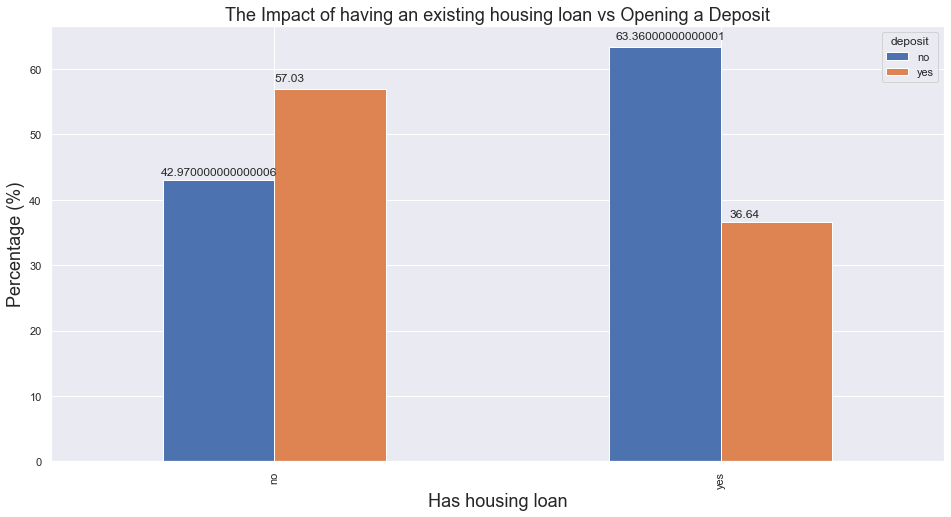

In [180]:
sns.set(rc={'figure.figsize':(16,8)})
ax = yes_no_by_temp_housing.plot(kind='bar', stacked=False)#, order=['0m','1m','2m', '3m', '6m','12m', '24m', '>24m'])
plt.title("The Impact of having an existing housing loan vs Opening a Deposit", fontsize=18)
plt.xlabel("Has housing loan", fontsize=18);
plt.ylabel("Percentage (%)", fontsize=18)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.02, p.get_height() * 1.02))
    

plt.show()

From the above, if you had a housing loan, you were less likely to subscribe to a deposit from this campaign.

## 3. Model data

In [15]:
df_full = df_raw.copy()

In [16]:
df_full.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [17]:
df_full[df_full.age.isnull()]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit


### Split train - test

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

stratifier = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for training_data_indexes, test_data_indexes in stratifier.split(df_full,df_full.loan):
    stratified_training_data = df_full.loc[training_data_indexes]
    stratified_test_data = df_full.loc[test_data_indexes]
    
    
#create copies
train = stratified_training_data.copy()
test = stratified_test_data.copy()

In [19]:
df_full

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


In [20]:
train.shape

(8929, 17)

In [21]:
train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
9867,55,retired,married,secondary,no,6690,no,no,cellular,30,apr,534,1,-1,0,unknown,no
10647,31,technician,single,secondary,no,433,no,no,cellular,11,aug,1504,2,-1,0,unknown,no
96,30,technician,single,tertiary,no,880,yes,yes,unknown,19,may,967,6,-1,0,unknown,yes
8334,41,services,married,primary,no,0,yes,no,cellular,17,jul,18,11,-1,0,unknown,no
6135,39,housemaid,married,primary,no,13338,no,no,cellular,11,aug,103,4,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3830,53,management,married,tertiary,no,3591,yes,no,cellular,5,aug,306,2,181,2,other,yes
10071,33,admin.,married,secondary,no,920,no,no,cellular,13,aug,111,1,105,1,success,no
2994,31,technician,married,secondary,no,684,yes,no,cellular,7,dec,620,3,-1,0,unknown,yes
335,44,services,married,secondary,no,522,no,yes,unknown,20,jun,911,1,-1,0,unknown,yes


In [22]:
test.shape

(2233, 17)

### Build transformation pipeline

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8929 entries, 9867 to 9672
Data columns (total 17 columns):
age          8929 non-null int64
job          8929 non-null object
marital      8929 non-null object
education    8929 non-null object
default      8929 non-null object
balance      8929 non-null int64
housing      8929 non-null object
loan         8929 non-null object
contact      8929 non-null object
day          8929 non-null int64
month        8929 non-null object
duration     8929 non-null int64
campaign     8929 non-null int64
pdays        8929 non-null int64
previous     8929 non-null int64
poutcome     8929 non-null object
deposit      8929 non-null object
dtypes: int64(7), object(10)
memory usage: 1.2+ MB


In [25]:
numeric_cols = train.select_dtypes(include=np.number).columns.tolist()
#numeric_cols.remove('deposit')

In [26]:
numeric_cols

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [27]:
categoric_cols = train.select_dtypes(exclude=np.number).columns.tolist()
#remove target variable, to ensure that we end up with feature set, not label
categoric_cols.remove('deposit')
categoric_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [28]:
from sklearn.preprocessing import OneHotEncoder,StandardScaler

In [29]:
# Build pipelines to scale numerical features and encode categorical

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Making pipelines
numerical_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(numeric_cols)),
    ("std_scaler", StandardScaler()),
])

categorical_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(categoric_cols)),
    ("cat_encoder",  OneHotEncoder(handle_unknown='ignore'))
])

from sklearn.pipeline import FeatureUnion
# https://stackoverflow.com/a/52666039
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("numerical_pipeline", numerical_pipeline),
        ("categorical_pipeline", categorical_pipeline),
    ])

In [30]:
X_train = preprocess_pipeline.fit_transform(train)
X_train = X_train.toarray()
X_train

array([[ 1.14643868,  1.68761105,  1.69442818, ...,  0.        ,
         0.        ,  1.        ],
       [-0.86102339, -0.35066205, -0.5560058 , ...,  0.        ,
         0.        ,  1.        ],
       [-0.94466765, -0.20504785,  0.39154535, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.86102339, -0.26889658, -1.02978138, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.2263519 , -0.32166951,  0.50998924, ...,  0.        ,
         0.        ,  1.        ],
       [-0.61009063, -0.34740446,  1.69442818, ...,  1.        ,
         0.        ,  0.        ]])

In [31]:
X_train.shape

(8929, 51)

In [32]:
categorical_pipeline["cat_encoder"].get_feature_names()

array(['x0_admin.', 'x0_blue-collar', 'x0_entrepreneur', 'x0_housemaid',
       'x0_management', 'x0_retired', 'x0_self-employed', 'x0_services',
       'x0_student', 'x0_technician', 'x0_unemployed', 'x0_unknown',
       'x1_divorced', 'x1_married', 'x1_single', 'x2_primary',
       'x2_secondary', 'x2_tertiary', 'x2_unknown', 'x3_no', 'x3_yes',
       'x4_no', 'x4_yes', 'x5_no', 'x5_yes', 'x6_cellular',
       'x6_telephone', 'x6_unknown', 'x7_apr', 'x7_aug', 'x7_dec',
       'x7_feb', 'x7_jan', 'x7_jul', 'x7_jun', 'x7_mar', 'x7_may',
       'x7_nov', 'x7_oct', 'x7_sep', 'x8_failure', 'x8_other',
       'x8_success', 'x8_unknown'], dtype=object)

In [33]:
# do not fit the scaler to test features
X_test = preprocess_pipeline.transform(test)
X_test = X_test.toarray()
X_test

array([[-0.44280213, -0.48226862,  1.81287207, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.3936404 , -0.2070024 ,  0.39154535, ...,  0.        ,
         0.        ,  1.        ],
       [-0.10822512, -0.45913975,  1.57598429, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 3.73941053, -0.08288828, -0.20067412, ...,  0.        ,
         1.        ,  0.        ],
       [-1.36288891,  0.47741694, -1.62200085, ...,  0.        ,
         0.        ,  1.        ],
       [-0.86102339,  8.29237164,  0.62843314, ...,  0.        ,
         0.        ,  1.        ]])

In [34]:
#instantiatie label from stratified datasets
y_train = train['deposit']
y_test = test['deposit']
y_train.shape

(8929,)

In [35]:
# encode label
from sklearn.preprocessing import LabelEncoder

encode = LabelEncoder()
y_train = encode.fit_transform(y_train)
y_test = encode.fit_transform(y_test)

In [36]:
feature_names = numeric_cols.copy()
feature_names.extend([col for col in categorical_pipeline["cat_encoder"].get_feature_names()])

### Train using cross-val

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, cross_val_predict


dict_classifiers = {
    'logistic_reg': LogisticRegression(),
    'support_vector_clf': SVC(),
    'knn_clf': KNeighborsClassifier(),
    'gradient_boosting_clf': GradientBoostingClassifier(),
    'random_forest_cld': RandomForestClassifier(),
    'naive_bayes_clf': GaussianNB(),
    'xgboost_clf': XGBClassifier()
}

dict_preds = {}

for this_classifier in dict_classifiers.keys():
    this_score = cross_val_score(dict_classifiers[this_classifier], X_train, y_train, cv=5)
    # https://stackoverflow.com/questions/25006369/what-is-sklearn-cross-validation-cross-val-score
    this_mean = this_score.mean()
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html
    dict_preds[this_classifier] = cross_val_predict(dict_classifiers[this_classifier], X_train, y_train, cv=5) #get predictions, for ROC curve
    print(this_classifier, this_mean)

logistic_reg 0.8265229583719329
support_vector_clf 0.8418654490335585
knn_clf 0.8047939130884586
gradient_boosting_clf 0.8467950448226297
random_forest_cld 0.831113284709519
naive_bayes_clf 0.7192280381654621
xgboost_clf 0.845450883207228


On just accuracy evaluation, GB classifier appears to perform the best but only marginally better than an svm.

### Evaluate confusion matrix

Plot confusion matrix to see precision and recall. Note the following:

- TN: Those we identified as not taking up a deposit, and in reality did not
- TP: Those we identfied as taking up a deposit, and in reality did
- FN: Those we identified as not taking up a deposit, but in reality did
- FP: Those we identified as taking up a deposit, but in reality did not


  			
- (top row) true positive, false positive
- (bottom row) false negative, true negative

In [38]:
from sklearn.metrics import confusion_matrix
#https://machinelearningmastery.com/confusion-matrix-machine-learning/
 
for this_classifier in dict_preds.keys():
    this_pred = dict_preds[this_classifier]
    confusion_results = confusion_matrix(y_train, this_pred)
    print(this_classifier, "\n\n", confusion_results, "\n\n")

logistic_reg 

 [[4008  689]
 [ 860 3372]] 


support_vector_clf 

 [[3921  776]
 [ 636 3596]] 


knn_clf 

 [[3972  725]
 [1018 3214]] 


gradient_boosting_clf 

 [[3932  765]
 [ 603 3629]] 


random_forest_cld 

 [[3947  750]
 [ 834 3398]] 


naive_bayes_clf 

 [[4032  665]
 [1842 2390]] 


xgboost_clf 

 [[3913  784]
 [ 596 3636]] 




From the above, comparing svm, gb and xgboost, unable to see a clear winner. Both have not insignificant false positives and negatives.

To have a single metric, we can plot a precision-recall curve.

### Evaluate precision-recall using AUC in ROC.

https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

In [39]:
from sklearn.metrics import roc_auc_score

for this_classifier in dict_preds.keys():
    print('{}: {}'.format(this_classifier, roc_auc_score(y_train, dict_preds[this_classifier])))

logistic_reg: 0.8250485066082078
support_vector_clf: 0.8422523043908894
knn_clf: 0.8025489764813883
gradient_boosting_clf: 0.847322130362742
random_forest_cld: 0.8216268337630945
naive_bayes_clf: 0.7115825348843104
xgboost_clf: 0.8461265949025099


Looking at AUC, all three are close but gradient boosting_clf is highest. However, given the recent surge in use of xgboost, let's go with this model for now.

### Tune XG Boost

https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

In [40]:
import xgboost as xgb

In [41]:
# https://stackoverflow.com/a/46943417
dtrain = xgb.DMatrix(X_train, label=y_train,feature_names=feature_names)
dtest = xgb.DMatrix(X_test, label=y_test,feature_names=feature_names)

In [42]:
from sklearn.metrics import mean_absolute_error

In [43]:
# https://xgboost.readthedocs.io/en/latest/parameter.html
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
}

params['eval_metric'] = "auc"
params['verbosity'] = 0

num_boost_round = 999

**Set the number of boosting rounds or trees to build, defined by num_boost_round**

If metric has not improved for n number of rounds (defined by early_stopping_rounds), we print the best number of trees to build.

Note, num_boost_round is highly dependent on other hyperparams. Therefore, we will retune this at the end of our various grid-searches.

In [44]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-auc:0.86743
Will train until Test-auc hasn't improved in 10 rounds.
[1]	Test-auc:0.878866
[2]	Test-auc:0.885514
[3]	Test-auc:0.893679
[4]	Test-auc:0.896937
[5]	Test-auc:0.902464
[6]	Test-auc:0.904215
[7]	Test-auc:0.907146
[8]	Test-auc:0.908715
[9]	Test-auc:0.908837
[10]	Test-auc:0.910888
[11]	Test-auc:0.91332
[12]	Test-auc:0.914129
[13]	Test-auc:0.913905
[14]	Test-auc:0.915127
[15]	Test-auc:0.915334
[16]	Test-auc:0.915759
[17]	Test-auc:0.915609
[18]	Test-auc:0.915952
[19]	Test-auc:0.915721
[20]	Test-auc:0.915672
[21]	Test-auc:0.916289
[22]	Test-auc:0.916593
[23]	Test-auc:0.916565
[24]	Test-auc:0.917327
[25]	Test-auc:0.917475
[26]	Test-auc:0.917339
[27]	Test-auc:0.917091
[28]	Test-auc:0.916657
[29]	Test-auc:0.917013
[30]	Test-auc:0.917651
[31]	Test-auc:0.918028
[32]	Test-auc:0.918231
[33]	Test-auc:0.917982
[34]	Test-auc:0.917581
[35]	Test-auc:0.917318
[36]	Test-auc:0.917238
[37]	Test-auc:0.917549
[38]	Test-auc:0.917883
[39]	Test-auc:0.917788
[40]	Test-auc:0.917992
[41]	Test-auc

Best boosting rounds is 32 ie 32 trees to build.

**Cross-validation**

Initial cv to see baseline AUC.

In [45]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'auc'},
    early_stopping_rounds=10
)

cv_results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.895352,0.001029,0.877857,0.006407
1,0.910791,0.002462,0.889958,0.004376
2,0.920619,0.001720,0.897551,0.004856
3,0.927345,0.001723,0.902645,0.004753
4,0.933272,0.000487,0.906412,0.004667
5,0.937635,0.000953,0.908748,0.004062
6,0.942217,0.000453,0.911156,0.003657
7,0.945193,0.000666,0.912237,0.003584
8,0.948804,0.001136,0.913558,0.003307
9,0.951408,0.001344,0.915227,0.003081


AUC for validation set is lower than training set, indicating likely overfitting.

**Gridsearch - Parameters max_depth and min_child_weight:**

"These parameters add constraints on the architecture of the trees.
- **max_depth** is the maximum number of nodes allowed from the root to the farthest leaf of a tree. Deeper trees can model more complex relationships by adding more nodes, but as we go deeper, splits become less relevant and are sometimes only due to noise, causing the model to overfit.

- **min_child_weight** is the minimum weight (or number of samples if all samples have a weight of 1) required in order to create a new node in the tree. A smaller min_child_weight allows the algorithm to create children that correspond to fewer samples, thus allowing for more complex trees, but again, more likely to overfit."

Source: https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f



In [46]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(6,9)
    for min_child_weight in range(1,8)
]

In [47]:
# Define initial best params and AUC
# min_mae = float("Inf") # use this if for MAE
max_auc = 0
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds=10
    )
    # Update best AUC
    mean_auc = cv_results['test-auc-mean'].max() 
    # mean_rmse = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], max_auc))

CV with max_depth=6, min_child_weight=1
	AUC 0.9226512000000001 for 26 rounds
CV with max_depth=6, min_child_weight=2
	AUC 0.9229571999999999 for 24 rounds
CV with max_depth=6, min_child_weight=3
	AUC 0.9234762 for 26 rounds
CV with max_depth=6, min_child_weight=4
	AUC 0.92249 for 20 rounds
CV with max_depth=6, min_child_weight=5
	AUC 0.9214832 for 32 rounds
CV with max_depth=6, min_child_weight=6
	AUC 0.9228764 for 22 rounds
CV with max_depth=6, min_child_weight=7
	AUC 0.9229794 for 33 rounds
CV with max_depth=7, min_child_weight=1
	AUC 0.9206948 for 22 rounds
CV with max_depth=7, min_child_weight=2
	AUC 0.9211886000000001 for 17 rounds
CV with max_depth=7, min_child_weight=3
	AUC 0.9200704 for 19 rounds
CV with max_depth=7, min_child_weight=4
	AUC 0.922078 for 26 rounds
CV with max_depth=7, min_child_weight=5
	AUC 0.9229255999999999 for 17 rounds
CV with max_depth=7, min_child_weight=6
	AUC 0.9230138 for 22 rounds
CV with max_depth=7, min_child_weight=7
	AUC 0.9220010000000001 for 17

In [48]:
params['max_depth'] = 6
params['min_child_weight'] = 3

In [49]:
params

{'max_depth': 6,
 'min_child_weight': 3,
 'eta': 0.3,
 'subsample': 1,
 'colsample_bytree': 1,
 'objective': 'reg:linear',
 'eval_metric': 'auc',
 'verbosity': 0}

**Gridsearch - Parameters subsample and colsample_bytree:**

"These parameters control the sampling of the dataset that is done at each boosting round.
Instead of using the whole training set every time, we can build a tree on slightly different data at each step, which makes it less likely to overfit to a single sample or feature.

- **subsample** corresponds to the fraction of observations (the rows) to subsample at each step. By default it is set to 1 meaning that we use all rows.

- **colsample_bytree** corresponds to the fraction of features (the columns) to use. By default it is set to 1 meaning that we will use all features."

Source: https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

In [50]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(1,11)]
    for colsample in [i/10. for i in range(1,11)]
]

In [51]:
max_auc = 0
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds=10
    )
    # Update best AUC
    mean_auc = cv_results['test-auc-mean'].max() 
    # mean_rmse = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (subsample,colsample)
print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], max_auc))

CV with subsample=1.0, colsample=1.0
	AUC 0.9234762 for 26 rounds
CV with subsample=1.0, colsample=0.9
	AUC 0.9204584 for 30 rounds
CV with subsample=1.0, colsample=0.8
	AUC 0.9242253999999999 for 35 rounds
CV with subsample=1.0, colsample=0.7
	AUC 0.9235720000000001 for 21 rounds
CV with subsample=1.0, colsample=0.6
	AUC 0.9240358000000001 for 35 rounds
CV with subsample=1.0, colsample=0.5
	AUC 0.9244766 for 30 rounds
CV with subsample=1.0, colsample=0.4
	AUC 0.9243364 for 30 rounds
CV with subsample=1.0, colsample=0.3
	AUC 0.922176 for 31 rounds
CV with subsample=1.0, colsample=0.2
	AUC 0.9210178000000001 for 38 rounds
CV with subsample=1.0, colsample=0.1
	AUC 0.9157812 for 131 rounds
CV with subsample=0.9, colsample=1.0
	AUC 0.9228007999999999 for 25 rounds
CV with subsample=0.9, colsample=0.9
	AUC 0.9213813999999999 for 32 rounds
CV with subsample=0.9, colsample=0.8
	AUC 0.9247728000000001 for 28 rounds
CV with subsample=0.9, colsample=0.7
	AUC 0.9219604 for 33 rounds
CV with subsa

In [52]:
params['subsample'] = 0.9
params['colsample_bytree'] = 0.8

**Gridsearch - Parameters ETA:**

"The ETA parameter controls the learning rate. It corresponds to the shrinkage of the weights associated to features after each round, in other words it defines the amount of "correction" we make at each step (remember how each boosting round is correcting the errors of the previous).

In practice, having a lower eta makes our model more robust to overfitting thus, usually, the lower the learning rate, the best. But with a lower eta, we need more boosting rounds, which takes more time to train, sometimes for only marginal improvements."

Source: https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

In [53]:
%time
# This can take some time…

min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time
    
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds=10
    )
    # Update best AUC
    mean_auc = cv_results['test-auc-mean'].max() 
    # mean_rmse = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = eta
print("Best params: {}, AUC: {}".format(best_params, max_auc))

Wall time: 0 ns
CV with eta=0.3
Wall time: 0 ns
	AUC 0.9247728000000001 for 28 rounds
CV with eta=0.2
Wall time: 0 ns
	AUC 0.9241238 for 43 rounds
CV with eta=0.1
Wall time: 0 ns
	AUC 0.9265578 for 95 rounds
CV with eta=0.05
Wall time: 0 ns
	AUC 0.9270574 for 191 rounds
CV with eta=0.01
Wall time: 0 ns
	AUC 0.9280668000000001 for 855 rounds
CV with eta=0.005
Wall time: 0 ns
	AUC 0.9251242000000002 for 998 rounds
Best params: 0.01, MAE: 0.9280668000000001


In [54]:
params['eta'] = 0.01
params

{'max_depth': 6,
 'min_child_weight': 3,
 'eta': 0.01,
 'subsample': 0.9,
 'colsample_bytree': 0.8,
 'objective': 'reg:linear',
 'eval_metric': 'auc',
 'verbosity': 0}

**Cross-validation again, to decide on num_boost_rounds**

In [55]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-auc:0.861054
Will train until Test-auc hasn't improved in 10 rounds.
[1]	Test-auc:0.880528
[2]	Test-auc:0.883616
[3]	Test-auc:0.885029
[4]	Test-auc:0.890562
[5]	Test-auc:0.890139
[6]	Test-auc:0.891283
[7]	Test-auc:0.890935
[8]	Test-auc:0.88965
[9]	Test-auc:0.890139
[10]	Test-auc:0.889942
[11]	Test-auc:0.891755
[12]	Test-auc:0.891586
[13]	Test-auc:0.891239
[14]	Test-auc:0.891113
[15]	Test-auc:0.891316
[16]	Test-auc:0.89161
[17]	Test-auc:0.891731
[18]	Test-auc:0.892154
[19]	Test-auc:0.892745
[20]	Test-auc:0.892961
[21]	Test-auc:0.892882
[22]	Test-auc:0.893448
[23]	Test-auc:0.893635
[24]	Test-auc:0.893772
[25]	Test-auc:0.893783
[26]	Test-auc:0.894187
[27]	Test-auc:0.894132
[28]	Test-auc:0.895267
[29]	Test-auc:0.895072
[30]	Test-auc:0.89494
[31]	Test-auc:0.895646
[32]	Test-auc:0.895682
[33]	Test-auc:0.895671
[34]	Test-auc:0.896133
[35]	Test-auc:0.896223
[36]	Test-auc:0.896116
[37]	Test-auc:0.896086
[38]	Test-auc:0.896532
[39]	Test-auc:0.896585
[40]	Test-auc:0.896735
[41]	Test-auc:

[345]	Test-auc:0.915442
[346]	Test-auc:0.915451
[347]	Test-auc:0.915464
[348]	Test-auc:0.915492
[349]	Test-auc:0.915527
[350]	Test-auc:0.915496
[351]	Test-auc:0.915532
[352]	Test-auc:0.915573
[353]	Test-auc:0.915617
[354]	Test-auc:0.91568
[355]	Test-auc:0.915701
[356]	Test-auc:0.915766
[357]	Test-auc:0.915814
[358]	Test-auc:0.915859
[359]	Test-auc:0.915863
[360]	Test-auc:0.915918
[361]	Test-auc:0.915969
[362]	Test-auc:0.915982
[363]	Test-auc:0.916035
[364]	Test-auc:0.91613
[365]	Test-auc:0.916174
[366]	Test-auc:0.916175
[367]	Test-auc:0.916177
[368]	Test-auc:0.916271
[369]	Test-auc:0.916305
[370]	Test-auc:0.916362
[371]	Test-auc:0.916478
[372]	Test-auc:0.916536
[373]	Test-auc:0.916569
[374]	Test-auc:0.916587
[375]	Test-auc:0.916613
[376]	Test-auc:0.91664
[377]	Test-auc:0.916729
[378]	Test-auc:0.916728
[379]	Test-auc:0.916753
[380]	Test-auc:0.916791
[381]	Test-auc:0.916825
[382]	Test-auc:0.916868
[383]	Test-auc:0.916873
[384]	Test-auc:0.916897
[385]	Test-auc:0.916923
[386]	Test-auc:0.91

[689]	Test-auc:0.921959
[690]	Test-auc:0.921947
[691]	Test-auc:0.921993
[692]	Test-auc:0.922012
[693]	Test-auc:0.922027
[694]	Test-auc:0.922061
[695]	Test-auc:0.922121
[696]	Test-auc:0.922144
[697]	Test-auc:0.922137
[698]	Test-auc:0.92214
[699]	Test-auc:0.922147
[700]	Test-auc:0.922167
[701]	Test-auc:0.922206
[702]	Test-auc:0.922182
[703]	Test-auc:0.922178
[704]	Test-auc:0.922189
[705]	Test-auc:0.922185
[706]	Test-auc:0.922214
[707]	Test-auc:0.922221
[708]	Test-auc:0.922243
[709]	Test-auc:0.922295
[710]	Test-auc:0.922318
[711]	Test-auc:0.922346
[712]	Test-auc:0.922353
[713]	Test-auc:0.922367
[714]	Test-auc:0.922388
[715]	Test-auc:0.922403
[716]	Test-auc:0.922434
[717]	Test-auc:0.922462
[718]	Test-auc:0.922461
[719]	Test-auc:0.922403
[720]	Test-auc:0.922402
[721]	Test-auc:0.922422
[722]	Test-auc:0.922424
[723]	Test-auc:0.922428
[724]	Test-auc:0.922442
[725]	Test-auc:0.922433
[726]	Test-auc:0.92247
[727]	Test-auc:0.922522
[728]	Test-auc:0.922509
[729]	Test-auc:0.92251
[730]	Test-auc:0.92

From the above, it looks like we need more rounds to get to the best AUC score on the test set compared to before we did our grid-search but at least we have a higher AUC now.




**Check results on training set**

Now that we know what our best number of boosting trees are needed, let's retrain the model again before saving.

In [56]:
num_boost_round = model.best_iteration + 1
num_boost_round

804

In [57]:
our_best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[0]	Test-auc:0.861054
[1]	Test-auc:0.880528
[2]	Test-auc:0.883616
[3]	Test-auc:0.885029
[4]	Test-auc:0.890562
[5]	Test-auc:0.890139
[6]	Test-auc:0.891283
[7]	Test-auc:0.890935
[8]	Test-auc:0.88965
[9]	Test-auc:0.890139
[10]	Test-auc:0.889942
[11]	Test-auc:0.891755
[12]	Test-auc:0.891586
[13]	Test-auc:0.891239
[14]	Test-auc:0.891113
[15]	Test-auc:0.891316
[16]	Test-auc:0.89161
[17]	Test-auc:0.891731
[18]	Test-auc:0.892154
[19]	Test-auc:0.892745
[20]	Test-auc:0.892961
[21]	Test-auc:0.892882
[22]	Test-auc:0.893448
[23]	Test-auc:0.893635
[24]	Test-auc:0.893772
[25]	Test-auc:0.893783
[26]	Test-auc:0.894187
[27]	Test-auc:0.894132
[28]	Test-auc:0.895267
[29]	Test-auc:0.895072
[30]	Test-auc:0.89494
[31]	Test-auc:0.895646
[32]	Test-auc:0.895682
[33]	Test-auc:0.895671
[34]	Test-auc:0.896133
[35]	Test-auc:0.896223
[36]	Test-auc:0.896116
[37]	Test-auc:0.896086
[38]	Test-auc:0.896532
[39]	Test-auc:0.896585
[40]	Test-auc:0.896735
[41]	Test-auc:0.896788
[42]	Test-auc:0.896863
[43]	Test-auc:0.897304
[

[348]	Test-auc:0.915492
[349]	Test-auc:0.915527
[350]	Test-auc:0.915496
[351]	Test-auc:0.915532
[352]	Test-auc:0.915573
[353]	Test-auc:0.915617
[354]	Test-auc:0.91568
[355]	Test-auc:0.915701
[356]	Test-auc:0.915766
[357]	Test-auc:0.915814
[358]	Test-auc:0.915859
[359]	Test-auc:0.915863
[360]	Test-auc:0.915918
[361]	Test-auc:0.915969
[362]	Test-auc:0.915982
[363]	Test-auc:0.916035
[364]	Test-auc:0.91613
[365]	Test-auc:0.916174
[366]	Test-auc:0.916175
[367]	Test-auc:0.916177
[368]	Test-auc:0.916271
[369]	Test-auc:0.916305
[370]	Test-auc:0.916362
[371]	Test-auc:0.916478
[372]	Test-auc:0.916536
[373]	Test-auc:0.916569
[374]	Test-auc:0.916587
[375]	Test-auc:0.916613
[376]	Test-auc:0.91664
[377]	Test-auc:0.916729
[378]	Test-auc:0.916728
[379]	Test-auc:0.916753
[380]	Test-auc:0.916791
[381]	Test-auc:0.916825
[382]	Test-auc:0.916868
[383]	Test-auc:0.916873
[384]	Test-auc:0.916897
[385]	Test-auc:0.916923
[386]	Test-auc:0.91696
[387]	Test-auc:0.91702
[388]	Test-auc:0.917027
[389]	Test-auc:0.9170

[692]	Test-auc:0.922012
[693]	Test-auc:0.922027
[694]	Test-auc:0.922061
[695]	Test-auc:0.922121
[696]	Test-auc:0.922144
[697]	Test-auc:0.922137
[698]	Test-auc:0.92214
[699]	Test-auc:0.922147
[700]	Test-auc:0.922167
[701]	Test-auc:0.922206
[702]	Test-auc:0.922182
[703]	Test-auc:0.922178
[704]	Test-auc:0.922189
[705]	Test-auc:0.922185
[706]	Test-auc:0.922214
[707]	Test-auc:0.922221
[708]	Test-auc:0.922243
[709]	Test-auc:0.922295
[710]	Test-auc:0.922318
[711]	Test-auc:0.922346
[712]	Test-auc:0.922353
[713]	Test-auc:0.922367
[714]	Test-auc:0.922388
[715]	Test-auc:0.922403
[716]	Test-auc:0.922434
[717]	Test-auc:0.922462
[718]	Test-auc:0.922461
[719]	Test-auc:0.922403
[720]	Test-auc:0.922402
[721]	Test-auc:0.922422
[722]	Test-auc:0.922424
[723]	Test-auc:0.922428
[724]	Test-auc:0.922442
[725]	Test-auc:0.922433
[726]	Test-auc:0.92247
[727]	Test-auc:0.922522
[728]	Test-auc:0.922509
[729]	Test-auc:0.92251
[730]	Test-auc:0.92249
[731]	Test-auc:0.92251
[732]	Test-auc:0.9225
[733]	Test-auc:0.922489

In [58]:
params

{'max_depth': 6,
 'min_child_weight': 3,
 'eta': 0.01,
 'subsample': 0.9,
 'colsample_bytree': 0.8,
 'objective': 'reg:linear',
 'eval_metric': 'auc',
 'verbosity': 0}

In [59]:
XGBClassifier(num_boost_round=num_boost_round)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_boost_round=804, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [60]:
dict_classifiers['xgboost_clf'] = XGBClassifier(colsample_bytree=0.8, eta=0.01,
                      eval_metric='auc', max_depth=6,
                      min_child_weight=3, objective='reg:linear',
                      subsample=0.9,seed=42,num_boost_round=804,verbosity=0)

dict_classifiers

{'logistic_reg': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False),
 'support_vector_clf': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
     kernel='rbf', max_iter=-1, probability=False, random_state=None,
     shrinking=True, tol=0.001, verbose=False),
 'knn_clf': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                      weights='uniform'),
 'gradient_boosting_clf': GradientBoostingClassifier(criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='deviance', max_depth=3,
               

In [61]:
# accuracy
revised_score = cross_val_score(dict_classifiers['xgboost_clf'], X_train, y_train, cv=5)

revised_score.mean()

0.8604564870156233

In [62]:
revised_preds = cross_val_predict(dict_classifiers['xgboost_clf'], X_train, y_train, cv=5)

In [63]:
confusion_results = confusion_matrix(y_train, revised_preds)
confusion_results

array([[3959,  738],
       [ 508, 3724]], dtype=int64)

In [64]:
revised_auc = roc_auc_score(y_train, revised_preds)
revised_auc

0.8614203129295013

In [65]:
our_best_model.save_model("my_model.model")

## 4) Make predictions

https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/

"To make predictions we use the scikit-learn function model.predict().

By default, the predictions made by XGBoost are probabilities. Because this is a binary classification problem, each prediction is the probability of the input pattern belonging to the first class. We can easily convert them to binary class values by rounding them to 0 or 1."

In [80]:
our_best_predictions = our_best_model.predict(dtest)
final_best_predictions = [abs(round(value)) for value in our_best_predictions]

In [67]:
confusion_results = confusion_matrix(y_test, final_best_predictions)
confusion_results

array([[976, 200],
       [128, 929]], dtype=int64)

In [68]:
revised_auc = roc_auc_score(y_test, final_best_predictions)
revised_auc

0.8544172635941794

In [69]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, final_best_predictions)

0.8531124048365427

From here, we see that the test AUC is not too far from training and validation. This means we are not overfitting.

Overall, acceptable results.

Next, we will see what were key features in helping the model make it's decisions.

## 5) Key features

In [74]:
from xgboost import plot_importance

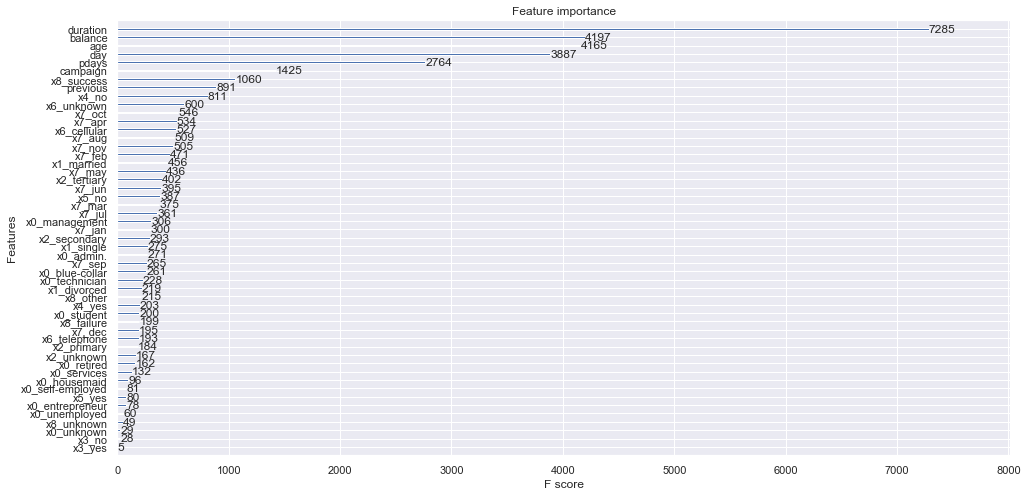

In [75]:
plot_importance(our_best_model)
plt.show()

We see the following features were more important for the boosted decisions trees to model the data:

- 'duration': duration (in miliseconds) of last contact<br>
- 'balance': balance of the individual<br>
- 'age': age of this person<br>
- 'pdays': days since last contact<br>
- 'campaign': number of contacts for this person in this campaign<br>
- 'x6_success': if outcome of the previous marketing campaign was succesful<br>
- 'previous': number of times someone was contacted in previous campaign<br>
- 'x4_housing': does not have a housing loan<br>

Let's check these against a basic logistic regression model to see if these features also hold true as significant.

In [224]:
import statsmodels.api as sm

In [225]:
model = sm.GLM.from_formula("deposit ~ duration + balance + age + pdays + campaign + poutcome + previous + housing ", family=sm.families.Binomial(), data=train)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Generalized Linear Model Regression Results                        
===========================================================================================
Dep. Variable:     ['deposit[no]', 'deposit[yes]']   No. Observations:                 8929
Model:                                         GLM   Df Residuals:                     8918
Model Family:                             Binomial   Df Model:                           10
Link Function:                               logit   Scale:                          1.0000
Method:                                       IRLS   Log-Likelihood:                -4149.4
Date:                             Sat, 04 Jan 2020   Deviance:                       8298.7
Time:                                     17:33:08   Pearson chi2:                 2.87e+06
No. Iterations:                                  6                                         
Covariance Type:                         nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.6463      0.175      3.697      0.000       0.304       0.989
poutcome[T.other]      -0.1307      0.139     -0.943      0.346      -0.402       0.141
poutcome[T.success]    -2.2493      0.151    -14.873      0.000      -2.546      -1.953
poutcome[T.unknown]     0.5998      0.144      4.158      0.000       0.317       0.883
housing[T.yes]          1.2017      0.058     20.718      0.000       1.088       1.315
duration               -0.0050      0.000    -39.154      0.000      -0.005      -0.005
balance             -4.576e-05   9.38e-06     -4.880      0.000   -6.41e-05   -2.74e-05
age                     0.0033      0.002      1.438      0.150      -0.001       0.008
pdays                  -0.0002      0.000     -0.546      0.585      -0.001       0.001
campaign                0.1307      0.014      9.085      0.000       0.103       0.159
previous               -0.0325      0.016     -1.978      0.048      -0.065      -0.000
=======================================================================================
"""

From the above, we actually see that age and pdays (days since last contact) may not necessarily have a significant relationship with the odds of someone subscribing to the term deposit (p-values below 0.05). Slightly different conclusion from our xgboost model.

Next, we also look at multicollineariy between previous campaign number of contacts and durations, with previous campaign success. If they were correlated, this may mean our standard errors from the logistic regression model may be wrong, and this would result in incorrect p-values.

In [226]:
dummy_df = pd.DataFrame(train[['duration', 'previous', 'poutcome']])
dummy_df['poutcome'] = dummy_df.apply(lambda row: 1 if row['poutcome']=='success' else 0,axis=1)
dummy_df_cor = dummy_df.corr()
pd.DataFrame(np.linalg.inv(dummy_df.corr().values), index = dummy_df_cor.index, columns=dummy_df_cor.columns)

,duration,previous,poutcome
duration,1.001542,0.033265,0.012602
previous,0.033265,1.125471,-0.373523
poutcome,0.012602,-0.373523,1.124524


The diagonal values indicate the variance inflation factor (VIF) which is a metric for multicollinearity between two predictors. Values below 5 indicate that is collinearity is absent. As such, the signifance of these features are valid.

## 6) Recommended actions for a marketing strategy

Based on the analysis we conducted in the earlier sections of this notebook as well as the insights generated from machine learning, general guidance would be to avoid people with overdrawn bank balances, existing housing loans, and we pestered and failed with in previous attempts.

More precide tactics would be as follows:

- 'duration' and 'previous': Best to try to avoid individuals we 'pestered' before if our previous campaign failed. However, if we had success with them before, we may see success again regardless of how much we pestered them before.<br>
- 'balance': Perhaps greater campaign success by not approaching individuals with overdrawn bank balances<br>
- 'campaign': Repeatedly pestering someone this campaign will make them less likely to sign up. Therefore, need to make sure we build rapport with minimal repeated attempts.<br>
- 'x6_success': Focus on inidividuals where we had success with in our previous campaign<br>
- 'x4_housing': Focus on individuals without housing loan debts (perhaps indicative of additional capital to use).<br>

Other tactics that may be helpful:
- 'age': Approach more people who are either in their 20's or 60's and above<br>
- 'pdays': Perhaps consider focusing on people we may not have spoken to in a while<br>

## 7) Steps to improve analysis

In future iterations of this analysis, we will likely focus on the following:

- Improve false negative rates. This is potential cash on the table, valuable opportunities we may be missing out on
- Try a neural network to see if any improvements

## 8) Resources:

1. https://www.kaggle.com/janiobachmann/bank-marketing-campaign-opening-a-term-deposit: Main reference notebook for steps to proceed

2. https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f: Tips to tune xgboost

3. https://stackoverflow.com/a/31434967: Toggle code button

4. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html: Logic of cross-val predictions

5. https://machinelearningmastery.com/confusion-matrix-machine-learning/: Code confusion matrix

6. https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5: Explanation of AUC for ROC

7. https://xgboost.readthedocs.io/en/latest/parameter.html: XGBoost parameters

8. https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/: Converting XGBoost Classifier output to binary

9. https://stackoverflow.com/questions/25006369/what-is-sklearn-cross-validation-cross-val-score: Logic of cross-val score

10. https://towardsdatascience.com/multicollinearity-in-data-science-c5f6c0fe6edf: Explanation of variance inflation factor

11. https://stackoverflow.com/a/51463149: Code for variance inflation factor